In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import sys
if not '..' in sys.path:
    sys.path.append('..')
from Pipeline.PPP import *

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

#### Globals

In [2]:
PATH_RAW = '../data/raw_data/'
PATH_DATA = '../data/data/'
PATH_MODELS = '../../models/'
PATH_IMAGES = '../assets/images/'

METHOD = 'multiclass'

## Load data

In [3]:
# Amazon
data = pd.read_csv(PATH_RAW + "2830_reviews.csv")

train, test = file_split(data, 0.2, 'text_review', 'tag')
train, val = preprocess_train(train, text_column='text_review', tag_column='tag', pattern='abcd')
test = preprocess_test(test, text_column='text_review', tag_column='tag', pattern='abcd')

X_train, y_train, y_bin_train = train.drop(['tag', 'bin_tag'], axis=1), train['tag'].copy(), train['bin_tag'].copy()
X_val, y_val, y_bin_val = val.drop(['tag', 'bin_tag'], axis=1), val['tag'].copy(), val['bin_tag'].copy()
X_test, y_test, y_bin_test = test.drop(['tag', 'bin_tag'], axis=1), test['tag'].copy(), test['bin_tag'].copy()

Splitting files...
Splitting finished.
Preprocessing of the training data...
Preprocessing finished in 25.073704957962036 seconds.
Preprocessing of the test data...
Preprocessing finished in 6.366779088973999 seconds.


In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   text_review    2036 non-null   object 
 1   read_score     2036 non-null   float64
 2   sentiment      2036 non-null   float64
 3   num_upper      2036 non-null   int64  
 4   num_discourse  2036 non-null   int64  
 5   num_tokens     2036 non-null   int64  
 6   num_char       2036 non-null   int64  
 7   text_pos       2036 non-null   object 
 8   lemmas         2036 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 143.3+ KB


In [4]:
# SOCC
test_socc = pd.read_csv(PATH_RAW + "socc.csv")

test_socc = preprocess_test(test_socc, text_column='comment_text', tag_column='is_constructive', pattern='yesno')
test_socc = test_socc.rename(columns={'comment_text': 'text_review', 'is_constructive': 'bin_tag'})

X_test_socc, y_bin_test_socc = test_socc.drop(['bin_tag'], axis=1), test_socc['bin_tag'].copy()

In [5]:
# C3 (extended version of SOCC)
test_c3 = pd.read_csv(PATH_RAW + "C3.csv")

test_c3 = preprocess_test(test_c3, text_column='comment_text', tag_column='constructive_binary', pattern=None)
test_c3 = test_c3.rename(columns={'comment_text': 'text_review', 'constructive_binary': 'bin_tag'})

X_test_c3, y_bin_test_c3 = test_c3.drop(['bin_tag'], axis=1), test_c3['bin_tag'].copy()

In [6]:
# Lists of data sets for testing
list_X_test = [X_test]
list_y_test = [y_test]

list_X_bin_test = [X_test, X_test_socc, X_test_c3]
list_y_bin_test = [y_bin_test, y_bin_test_socc, y_bin_test_c3]

## Model training

We list the features to use in the Pipeline

In [7]:
numeric_features = list(X_train[['read_score', 'sentiment', 'num_tokens', 'num_char']])
text_features = list(X_train[['text_review', 'text_pos', 'lemmas']])

Custom transformer to transform the data and create a feature space

In [8]:
trans = ColumnTransformer(transformers=[
            ('review', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,1)), 'text_review'),
            ('pos', TfidfVectorizer(encoding='utf-8', ngram_range=(1,2)), 'text_pos'),
            ('lemma', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,1)), 'lemmas'),
            ('num_attr', StandardScaler(), numeric_features),
            ])

Pipeline to sequentially transform the data and fit an estimator

In [9]:
pipeline = Pipeline([
                       ('union', trans),
                       ('clf', LogisticRegression(max_iter=500, random_state=42))
])

GridSearch with 5 fold cross-validation to find the best set of features

In [10]:
param_grid = [
              {
                 'union__review__ngram_range': [(1,1), (1,2)],
                 #'union__pos__ngram_range': [(1,1), (1,2)],
                 'union__lemma__ngram_range': [(1,1), (1,2)],
                 'clf': [RandomForestClassifier(),],
                 'clf__n_estimators': [ 150, 175],
                 'clf__class_weight': ['balanced', None],
               }
            ,{
                 'union__review__ngram_range': [(1,1), (1,2)],
                 #'union__pos__ngram_range': [(1,1), (1,2)],
                 'union__lemma__ngram_range': [(1,1), (1,2)],
                 'clf': [LogisticRegression(),],
                 'clf__max_iter': [500, 1000],
                 'clf__C': [0.5, 1.0],
                 'clf__class_weight': ['balanced', None],
              }
]

# Training with all possible configurations
model = GridSearchCV(pipeline,
                      param_grid=param_grid,
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=5,
                      verbose=1)

Model fitting...

In [18]:
if METHOD.lower() == 'binary':
    model.fit(X_train, y_bin_train)
elif METHOD.lower() == 'multiclass':
    model.fit(X_train, y_train)
else:
    raise ValueError('You must choose \'binary\' or \'multiclas\'.')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  7.8min finished


## Model validation

Output of best parameter set and best accuracy average score

In [19]:
print(model.best_score_)
print(model.best_params_)

0.621817940935588
{'clf': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=175,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'clf__class_weight': None, 'clf__n_estimators': 175, 'union__lemma__ngram_range': (1, 1), 'union__review__ngram_range': (1, 1)}


In [20]:
if METHOD.lower() == 'binary':
    y_pred_val = model.predict(X_val)
    print("Accuracy:", accuracy_score(y_bin_val, y_pred_val))
    print("F1 Score:", f1_score(y_bin_val, y_pred_val, average='weighted'))
    print(classification_report(y_bin_val, y_pred_val))
elif METHOD.lower() == 'multiclass':
    y_pred_val = model.predict(X_val)
    print("Accuracy:", accuracy_score(y_val, y_pred_val))
    print("F1 Score:", f1_score(y_val, y_pred_val, average='weighted'))
    print(classification_report(y_val, y_pred_val))
else:
    raise ValueError('You must choose \'binary\' or \'multiclas\'.')

Accuracy: 0.6299559471365639
F1 Score: 0.6167297088533967
              precision    recall  f1-score   support

           0       1.00      0.31      0.48        32
           1       0.64      0.62      0.63        73
           2       0.59      0.82      0.68        88
           3       0.67      0.47      0.55        34

    accuracy                           0.63       227
   macro avg       0.72      0.55      0.58       227
weighted avg       0.67      0.63      0.62       227



Saving model

In [21]:
#pickle.dump(model, open(PATH_MODELS+'v0-2_multiclass.sav', 'wb'))

## Model testing (multiclass model)

Model 1
Accuracy: 0.588339222614841
F1 Score: 0.5744761883563154
              precision    recall  f1-score   support

           0       0.87      0.33      0.48        79
           1       0.63      0.51      0.56       183
           2       0.53      0.82      0.64       218
           3       0.70      0.41      0.51        86

    accuracy                           0.59       566
   macro avg       0.68      0.52      0.55       566
weighted avg       0.63      0.59      0.57       566



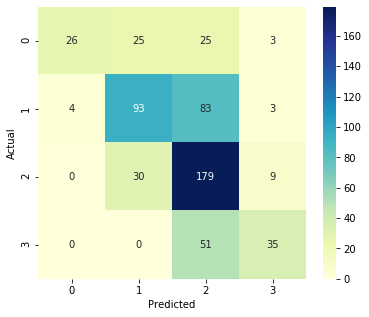

In [22]:
for i, (X, y) in enumerate(zip(list_X_test, list_y_test)):
    y_pred = model.predict(X)
    print('Model {}'.format(i+1))
    print("Accuracy:", accuracy_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred, average='weighted'))
    print(classification_report(y, y_pred))
    
    conf_mat = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print("="*53)

## Model testing (binary model)

Model 1
Accuracy: 0.7897526501766784
F1 Score: 0.789663487034458
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       262
           1       0.80      0.81      0.81       304

    accuracy                           0.79       566
   macro avg       0.79      0.79      0.79       566
weighted avg       0.79      0.79      0.79       566



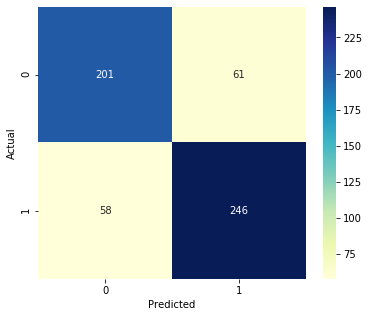

Model 2
Accuracy: 0.7190795781399808
F1 Score: 0.7120779209935939
              precision    recall  f1-score   support

           0       0.64      0.90      0.75       489
           1       0.87      0.56      0.68       554

    accuracy                           0.72      1043
   macro avg       0.76      0.73      0.71      1043
weighted avg       0.76      0.72      0.71      1043



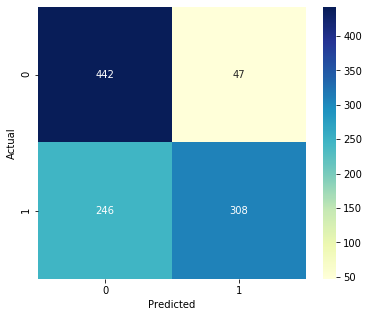

Model 3
Accuracy: 0.7545833333333334
F1 Score: 0.7526378661528698
              precision    recall  f1-score   support

         0.0       0.68      0.89      0.77      5484
         1.0       0.87      0.64      0.74      6516

    accuracy                           0.75     12000
   macro avg       0.77      0.77      0.75     12000
weighted avg       0.78      0.75      0.75     12000



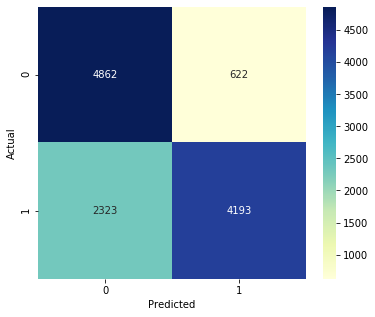

In [16]:
for i, (X, y) in enumerate(zip(list_X_bin_test, list_y_bin_test)):
    y_pred = model.predict(X)
    print('Model {}'.format(i+1))
    print("Accuracy:", accuracy_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred, average='weighted'))
    print(classification_report(y, y_pred))
    
    conf_mat = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print("="*53)